In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.metrics import mutual_info_score

In [4]:
from sklearn.feature_extraction import DictVectorizer

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
from sklearn.tree import DecisionTreeClassifier

In [10]:
from sklearn.metrics import roc_auc_score

In [11]:
from sklearn.tree import export_text

In [12]:
from sklearn.ensemble import RandomForestClassifier


In [5]:
import xgboost as xgb

## Data Preparation and EDA

In [6]:
df=pd.read_csv("./data/ecom_shipping.csv")

In [15]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [16]:
df.shape

(10999, 12)

In [7]:
df.columns=df.columns.str.lower()

In [8]:
df.rename(columns={'reached.on.time_y.n': 'reached_on_time'}, inplace=True)

In [9]:
df.drop('id', axis=1, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   warehouse_block      10999 non-null  object
 1   mode_of_shipment     10999 non-null  object
 2   customer_care_calls  10999 non-null  int64 
 3   customer_rating      10999 non-null  int64 
 4   cost_of_the_product  10999 non-null  int64 
 5   prior_purchases      10999 non-null  int64 
 6   product_importance   10999 non-null  object
 7   gender               10999 non-null  object
 8   discount_offered     10999 non-null  int64 
 9   weight_in_gms        10999 non-null  int64 
 10  reached_on_time      10999 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 945.4+ KB


In [21]:
df.describe()

,customer_care_calls,customer_rating,cost_of_the_product,prior_purchases,discount_offered,weight_in_gms,reached_on_time
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [22]:
for col in df.columns:
    print(df[col].value_counts())
    print()

warehouse_block
F    3666
D    1834
A    1833
B    1833
C    1833
Name: count, dtype: int64

mode_of_shipment
Ship      7462
Flight    1777
Road      1760
Name: count, dtype: int64

customer_care_calls
4    3557
3    3217
5    2328
6    1013
2     638
7     246
Name: count, dtype: int64

customer_rating
3    2239
1    2235
4    2189
5    2171
2    2165
Name: count, dtype: int64

cost_of_the_product
245    110
257    109
260    106
254    101
264    100
      ... 
107      5
99       5
120      5
96       5
122      4
Name: count, Length: 215, dtype: int64

prior_purchases
3     3955
2     2599
4     2155
5     1287
6      561
10     178
7      136
8      128
Name: count, dtype: int64

product_importance
low       5297
medium    4754
high       948
Name: count, dtype: int64

gender
F    5545
M    5454
Name: count, dtype: int64

discount_offered
10    860
2     858
6     849
9     845
3     840
     ... 
65     36
26     36
42     35
25     34
30     34
Name: count, Length: 65, dtype: in

analyzing the target

In [23]:
df.reached_on_time.value_counts(normalize=True)

reached_on_time
1    0.596691
0    0.403309
Name: proportion, dtype: float64

In [24]:
df.reached_on_time.mean()

0.5966906082371125

classifying features into categorical and numerical:

In [25]:
df.columns

Index(['warehouse_block', 'mode_of_shipment', 'customer_care_calls',
       'customer_rating', 'cost_of_the_product', 'prior_purchases',
       'product_importance', 'gender', 'discount_offered', 'weight_in_gms',
       'reached_on_time'],
      dtype='object')

In [10]:
numerical = ['customer_care_calls', 'cost_of_the_product', 'prior_purchases', 'discount_offered', 'weight_in_gms' ]

In [11]:
categorical = ['warehouse_block', 'mode_of_shipment','customer_rating', 'product_importance', 'gender']

In [28]:
df[categorical].nunique()

warehouse_block       5
mode_of_shipment      3
customer_rating       5
product_importance    3
gender                2
dtype: int64

### Feature importance

In [29]:
def mutual_info_reached_not_on_time_score(series):
    return mutual_info_score(series, df.reached_on_time)

In [30]:
mi = df[categorical].apply(mutual_info_reached_not_on_time_score)
mi.sort_values(ascending=False)

product_importance    0.000563
customer_rating       0.000146
warehouse_block       0.000049
mode_of_shipment      0.000034
gender                0.000011
dtype: float64

In [31]:
df[numerical].corrwith(df.reached_on_time).abs().sort_values(ascending=False)

discount_offered       0.397108
weight_in_gms          0.268793
cost_of_the_product    0.073587
customer_care_calls    0.067126
prior_purchases        0.055515
dtype: float64

## Splitting the data 

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [13]:
len(df_train), len(df_val), len(df_test)

(6599, 2200, 2200)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.reached_on_time.values
y_val = df_val.reached_on_time.values
y_test = df_test.reached_on_time.values

del df_train['reached_on_time']
del df_val['reached_on_time']
del df_test['reached_on_time']

In [16]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Model training with different algorithms

### Logistic regression

In [37]:
model_lr = LogisticRegression(solver='lbfgs')

In [38]:
model_lr.fit(X_train, y_train)

LogisticRegression()

In [40]:
y_pred_lr = model_lr.predict_proba(X_val)[:, 1]

In [41]:
y_pred_lr

array([0.51476941, 0.66353974, 0.39169663, ..., 0.46195007, 0.47716879,
       0.37431201])

In [47]:
not_on_time_decision_lr = (y_pred_lr >= 0.5)

In [50]:
print(f'accuracy: {(y_val == not_on_time_decision_lr).mean()} ')

accuracy: 0.6313636363636363 


### Logistic Regression with a smaller dataset

In [52]:
dict(zip(dv.get_feature_names_out(), model_lr.coef_[0].round(3)))

{'cost_of_the_product': -0.001,
 'customer_care_calls': -0.063,
 'customer_rating': 0.076,
 'discount_offered': 0.124,
 'gender=F': 0.019,
 'gender=M': 0.021,
 'mode_of_shipment=Flight': -0.005,
 'mode_of_shipment=Road': 0.003,
 'mode_of_shipment=Ship': 0.042,
 'prior_purchases': -0.009,
 'product_importance=high': 0.056,
 'product_importance=low': -0.027,
 'product_importance=medium': 0.011,
 'warehouse_block=A': -0.013,
 'warehouse_block=B': -0.005,
 'warehouse_block=C': 0.021,
 'warehouse_block=D': 0.026,
 'warehouse_block=F': 0.011,
 'weight_in_gms': -0.0}

In [53]:
small = ['customer_care_calls', 'customer_rating', 'discount_offered']

In [54]:
df_train[small].iloc[:10].to_dict(orient='records')

[{'customer_care_calls': 5, 'customer_rating': 5, 'discount_offered': 1},
 {'customer_care_calls': 5, 'customer_rating': 2, 'discount_offered': 35},
 {'customer_care_calls': 6, 'customer_rating': 3, 'discount_offered': 10},
 {'customer_care_calls': 4, 'customer_rating': 1, 'discount_offered': 10},
 {'customer_care_calls': 4, 'customer_rating': 5, 'discount_offered': 2},
 {'customer_care_calls': 6, 'customer_rating': 1, 'discount_offered': 65},
 {'customer_care_calls': 5, 'customer_rating': 2, 'discount_offered': 5},
 {'customer_care_calls': 3, 'customer_rating': 3, 'discount_offered': 3},
 {'customer_care_calls': 3, 'customer_rating': 3, 'discount_offered': 3},
 {'customer_care_calls': 3, 'customer_rating': 5, 'discount_offered': 47}]

In [55]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

In [56]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

DictVectorizer(sparse=False)

In [57]:
dv_small.get_feature_names_out()

array(['customer_care_calls', 'customer_rating', 'discount_offered'],
      dtype=object)

In [58]:
X_train_small = dv_small.transform(dicts_train_small)

In [59]:
X_val_small = dv_small.transform(dicts_val_small)

In [60]:
model_small = LogisticRegression(solver='lbfgs')
model_small.fit(X_train_small, y_train)

LogisticRegression()

In [64]:
y_pred_small = model_small.predict_proba(X_val_small)[:, 1]
not_on_time_decision_small = (y_pred_small >= 0.5)
print(f'accuracy: {(y_val == not_on_time_decision_small).mean()} ')

accuracy: 0.6154545454545455 


Training it with a smaller dataset, where we select what we think are the most important features, does not improve the model accuracy

## Decision tree

In [68]:
dt = DecisionTreeClassifier()

In [69]:
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [71]:
y_pred_dt = dt.predict_proba(X_val)[:, 1]
print(f'roc_auc_score: {roc_auc_score(y_val, y_pred_dt)}')

roc_auc_score: 0.6125066889274171


In [73]:
not_on_time_decision_dt = (y_pred_dt >= 0.5)
print(f'accuracy: {(y_val == not_on_time_decision_dt).mean()}')

accuracy: 0.6304545454545455


we check if it is overfitting:

In [74]:
y_pred_dt_train = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred_dt_train)

1.0

it is overfitting.

### Parameter tuning 

In [75]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred_dt = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_dt)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.702
   2 -> 0.736
   3 -> 0.742
   4 -> 0.745
   5 -> 0.749
   6 -> 0.742
  10 -> 0.722
  15 -> 0.693
  20 -> 0.648
None -> 0.611


depths of 3,4,5 and 6 are the ones that perform best so now we look for the best min_samples_leaf value with those depths

In [76]:
scores = []

for depth in [3 ,4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred_dt = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred_dt)
        
        scores.append((depth, s, auc))

In [77]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [78]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                     
max_depth             3      4      5      6
min_samples_leaf                            
1                 0.742  0.745  0.749  0.742
5                 0.742  0.745  0.749  0.742
10                0.743  0.742  0.744  0.733
15                0.743  0.746  0.748  0.739
20                0.743  0.746  0.748  0.739
100               0.743  0.740  0.741  0.741
200               0.743  0.736  0.740  0.743
500               0.738  0.739  0.742  0.743

we choose max_depth=5 and min_samples_leaf=5

In [79]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

In [80]:
y_pred_dt = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_dt)

In [81]:
print('roc_auc_score:', auc)

roc_auc_score: 0.7485896530319571


In [157]:
not_on_time_decision = (y_pred_dt >= 0.5)
print(f'accuracy: {(y_val == not_on_time_decision).mean()}')

accuracy: 0.6818181818181818


## Random Forest

we search for the best max_depth value:

In [83]:
scores = []

for d in [2,3,4,5, 10]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [84]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

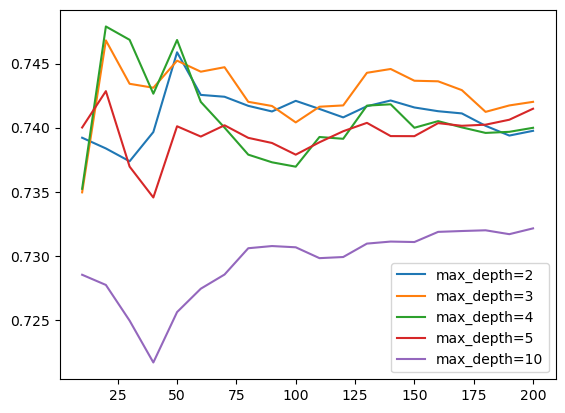

In [85]:
for d in [2,3,4,5, 10]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [86]:
max_depth = 3

now we search for the best min_samples_leaf value

In [87]:
scores = []

for s in [1, 3, 5, 10,20,30, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [90]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

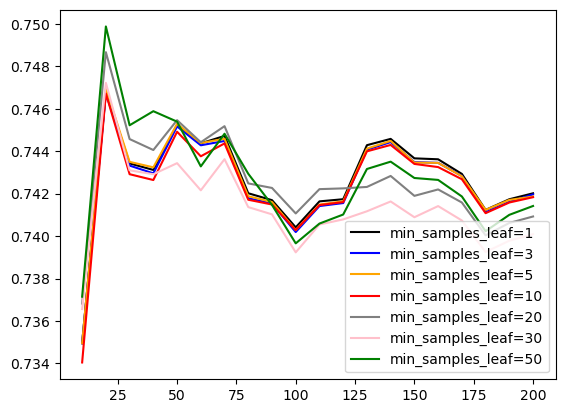

In [91]:
colors = ['black', 'blue', 'orange', 'red', 'grey','pink','green']
values = [1, 3, 5, 10,20,30, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [93]:
min_samples_leaf = 50

and finally we build the model with the parameters chosen and we select the number of estimators based on the plots

In [94]:
rf = RandomForestClassifier(n_estimators=20,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=50, n_estimators=20,
                       random_state=1)

In [95]:
y_pred_rf = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_rf)
print(auc)

0.7498747832787517


In [158]:
not_on_time_decision_rf = (y_pred_rf >= 0.5)
print(f'accuracy: {(y_val == not_on_time_decision_rf).mean()} ')

accuracy: 0.6681818181818182 


## xgboost

In [17]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [98]:
scores = {}

In [99]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [100]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [115]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [116]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

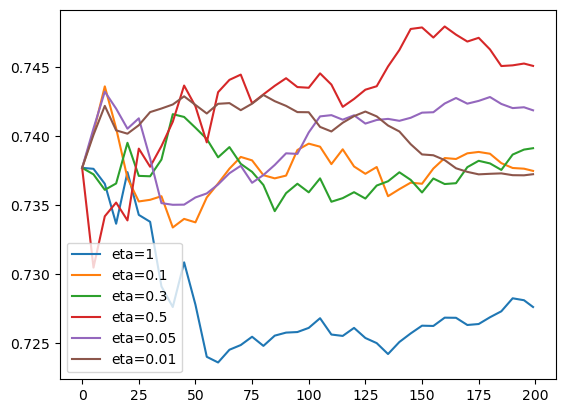

In [117]:
for key,df_score in scores.items():
    plt.plot(df_score.num_iter,df_score.val_auc,label=key)
plt.legend()

eta=0.1

now we tune the max_depth parameter:

In [118]:
scores={}

execute the next 2 cells with the following values for max_depth: 2,3,5,6,10

In [127]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [128]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

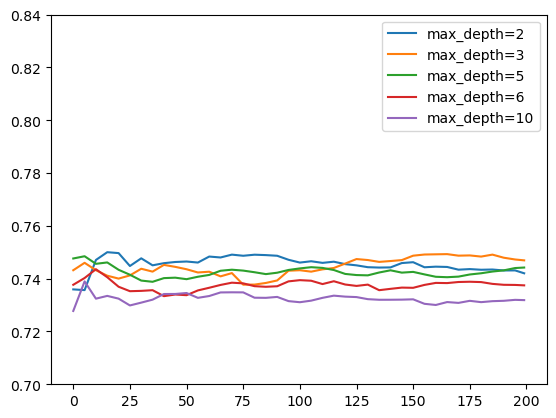

In [129]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.7, 0.84)
plt.legend()

max_depth=2

In [131]:
scores = {}

now we tune min_child_weight. execute the next 2 cells with the following values for min_child_weight: 1,5,10,30

In [138]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 2,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [139]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

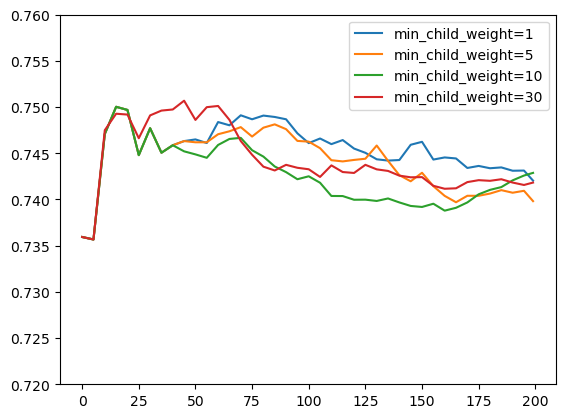

In [140]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.72, 0.76)
plt.legend()

min_child_weight=10

So now we train the final xgboost model with the values selected

In [159]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 5,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [160]:
y_pred_xgb = model_xgb.predict(dval)

In [161]:
roc_auc_score(y_val, y_pred_xgb)

0.7433279821913996

In [162]:
not_on_time_decision_xgb = (y_pred_xgb >= 0.5)
print(f'accuracy: {(y_val == not_on_time_decision_xgb).mean()}')

accuracy: 0.6813636363636364


# Results

table with the accuracy for each model trained:

| algorithm used to train the model   | accuracy for validation set        |
|----------|----------|
| Logistic regression  | 0.6313636363636363 |
| Logistic Regression with smaller dataset | 0.6154545454545455 |
| desicion tree | 0.6818181818181818 |
| random forest | 0.6681818181818182 |
| xgboost       | 0.6813636363636364 |
 

we choose the Xgboost model so now we train it with the full_train dataset,test it with the df_test and see if the accuracy is similar to the one we obtained with the validation dataset:

In [163]:
df_full_train = df_full_train.reset_index(drop=True)

In [164]:
y_full_train = df_full_train.reached_on_time.values

del df_full_train['reached_on_time']

In [165]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [1]:
print(X_test)

NameError: name 'X_test' is not defined

In [166]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

In [167]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 5,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model_xgb_2 = xgb.train(xgb_params, dfulltrain, num_boost_round=10)

In [168]:
y_pred_xgb_2 = model_xgb_2.predict(dtest)

In [169]:
roc_auc_score(y_test, y_pred_xgb_2)

0.7598859057324885

In [170]:
not_on_time_decision_xgb_2 = (y_pred_xgb_2 >= 0.50)
print((y_test == not_on_time_decision_xgb_2).mean())

0.6918181818181818


We achieved a 69% accuracy with the final XGBoost model, which will be used in production